In [1]:
import tensorflow as tf
import pickle, os, sys, time
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from utils.MyRAN92_v2 import ResidualAttentionModel_92
from contextlib import redirect_stdout

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
print(gpus)

1 Physical GPUs, 1 Logical GPUs
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
path = './models'
model_name = '/ran92_v2_arl'
model_path = path + model_name
if not os.path.exists(model_path):
    os.makedirs(model_path)
    print(model_path)
else:
    print(model_path + ' already exists.')

history_path = model_path + '/history'
if not os.path.exists(history_path):
    os.makedirs(history_path)
    print(history_path)
else:
    print(history_path + ' already exists.')

saved_model_path = model_path + '/saved_models'
if not os.path.exists(saved_model_path):
    os.makedirs(saved_model_path)
    print(saved_model_path)
else:
    print(saved_model_path + ' already exists.')

graph_path = model_path + '/graphs'
if not os.path.exists(graph_path):
    os.makedirs(graph_path)
    print(graph_path)
else:
    print(graph_path + ' already exists.')

./models/ran92_v2_arl
./models/ran92_v2_arl/history
./models/ran92_v2_arl/saved_models
./models/ran92_v2_arl/graphs


In [4]:
cifar10 = tf.keras.datasets.cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

In [5]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=20,
                                                          width_shift_range=0.2,
                                                          height_shift_range=0.2,
                                                          horizontal_flip=True,
                                                          validation_split=0.2)

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

# train_mean = np.mean(X_train, axis=(0,1,2))
# train_std = np.std(X_train, axis=(0,1,2))
# np.save("train_mean.npy", train_mean)
# np.save("train_std.npy", train_std)

train_mean = np.load("train_mean.npy")
train_std = np.load("train_std.npy")


In [6]:


X_train = X_train - X_train.mean()#train_mean) / train_std
X_test = (X_test - X_test.mean())


datagen.fit(X_train)

input_shape = X_train.shape[1:]
output_classes = 10

In [7]:
ran92 = ResidualAttentionModel_92(input_shape, output_classes, learning_type='ARL')

model = ran92.return_Model()

model.compile(tf.keras.optimizers.Adam(), 
              loss=tf.keras.losses.CategoricalCrossentropy(), 
              metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Model_Input (InputLayer)       [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 Conv1_In (Conv2D)              (None, 32, 32, 32)   864         ['Model_Input[0][0]']            
                                                                                                  
 BN_In (BatchNormalization)     (None, 32, 32, 32)   128         ['Conv1_In[0][0]']               
                                                                                                  
 ReLU_In (Activation)           (None, 32, 32, 32)   0           ['BN_In[0][0]']                  
                                                                                              

In [8]:
global summary_filename 
summary_filename = graph_path + '/{}'.format(model_name[1:]) + '_modelsummary.txt'
print(summary_filename)

./models/ran92_v2_arl/graphs/ran92_v2_arl_modelsummary.txt


In [9]:
with open(summary_filename, 'w') as f:
    with redirect_stdout(f):
        model.summary()

In [10]:
#%%

# dot_img_file = '/tmp/ran56.png'
# tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

# earlyStopping_TrainAcc = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=10)
# callbacks = list()
# callbacks.append(earlyStopping_TrainAcc)

callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor='accuracy'),
          tf.keras.callbacks.ReduceLROnPlateau(patience=5,  monitor='loss'), tf.keras.callbacks.ModelCheckpoint(saved_model_path + '/ran92_v2_ARL_training', monitor='loss', verbose=1, save_best_only=True, mode='min')]  


In [11]:
import time 

In [12]:
#%%
st = time.time()
ran92_v2_history = model.fit(datagen.flow(X_train, y_train, batch_size=64, subset='training'), validation_data=datagen.flow(X_train, y_train, batch_size=64, subset='validation'),
                    epochs=100, callbacks=callbacks)

ed = time.time()
print(f"took {ed-st} seconds")

Epoch 1/100
625/625 [==============================] - ETA: 0s - loss: 1.9451 - accuracy: 0.2639
Epoch 00001: loss improved from inf to 1.94513, saving model to ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


625/625 [==============================] - 224s 318ms/step - loss: 1.9451 - accuracy: 0.2639 - val_loss: 2.0165 - val_accuracy: 0.2671 - lr: 0.0010
Epoch 2/100
625/625 [==============================] - ETA: 0s - loss: 1.6856 - accuracy: 0.3747
Epoch 00002: loss improved from 1.94513 to 1.68561, saving model to ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


625/625 [==============================] - 185s 297ms/step - loss: 1.6856 - accuracy: 0.3747 - val_loss: 1.9259 - val_accuracy: 0.3390 - lr: 0.0010
Epoch 3/100
625/625 [==============================] - ETA: 0s - loss: 1.5466 - accuracy: 0.4311
Epoch 00003: loss improved from 1.68561 to 1.54657, saving model to ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


625/625 [==============================] - 189s 302ms/step - loss: 1.5466 - accuracy: 0.4311 - val_loss: 1.7457 - val_accuracy: 0.3899 - lr: 0.0010
Epoch 4/100
625/625 [==============================] - ETA: 0s - loss: 1.4381 - accuracy: 0.4735
Epoch 00004: loss improved from 1.54657 to 1.43805, saving model to ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


625/625 [==============================] - 189s 302ms/step - loss: 1.4381 - accuracy: 0.4735 - val_loss: 1.8319 - val_accuracy: 0.4148 - lr: 0.0010
Epoch 5/100
625/625 [==============================] - ETA: 0s - loss: 1.3291 - accuracy: 0.5176
Epoch 00005: loss improved from 1.43805 to 1.32915, saving model to ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


625/625 [==============================] - 187s 300ms/step - loss: 1.3291 - accuracy: 0.5176 - val_loss: 1.5711 - val_accuracy: 0.4871 - lr: 0.0010
Epoch 6/100
625/625 [==============================] - ETA: 0s - loss: 1.2452 - accuracy: 0.5502
Epoch 00006: loss improved from 1.32915 to 1.24519, saving model to ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


625/625 [==============================] - 187s 300ms/step - loss: 1.2452 - accuracy: 0.5502 - val_loss: 1.5052 - val_accuracy: 0.4965 - lr: 0.0010
Epoch 7/100
625/625 [==============================] - ETA: 0s - loss: 1.1757 - accuracy: 0.5776
Epoch 00007: loss improved from 1.24519 to 1.17568, saving model to ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


625/625 [==============================] - 187s 299ms/step - loss: 1.1757 - accuracy: 0.5776 - val_loss: 1.5076 - val_accuracy: 0.4861 - lr: 0.0010
Epoch 8/100
625/625 [==============================] - ETA: 0s - loss: 1.1214 - accuracy: 0.5981
Epoch 00008: loss improved from 1.17568 to 1.12141, saving model to ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


625/625 [==============================] - 184s 295ms/step - loss: 1.1214 - accuracy: 0.5981 - val_loss: 1.4784 - val_accuracy: 0.5041 - lr: 0.0010
Epoch 9/100
625/625 [==============================] - ETA: 0s - loss: 1.0663 - accuracy: 0.6183
Epoch 00009: loss improved from 1.12141 to 1.06626, saving model to ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


625/625 [==============================] - 186s 298ms/step - loss: 1.0663 - accuracy: 0.6183 - val_loss: 1.3280 - val_accuracy: 0.5681 - lr: 0.0010
Epoch 10/100
625/625 [==============================] - ETA: 0s - loss: 1.0083 - accuracy: 0.6409
Epoch 00010: loss improved from 1.06626 to 1.00834, saving model to ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


625/625 [==============================] - 186s 298ms/step - loss: 1.0083 - accuracy: 0.6409 - val_loss: 1.3430 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 11/100
625/625 [==============================] - ETA: 0s - loss: 0.9759 - accuracy: 0.6554
Epoch 00011: loss improved from 1.00834 to 0.97586, saving model to ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


625/625 [==============================] - 188s 301ms/step - loss: 0.9759 - accuracy: 0.6554 - val_loss: 1.3728 - val_accuracy: 0.5306 - lr: 0.0010
Epoch 12/100
625/625 [==============================] - ETA: 0s - loss: 0.9271 - accuracy: 0.6730
Epoch 00012: loss improved from 0.97586 to 0.92714, saving model to ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


625/625 [==============================] - 187s 300ms/step - loss: 0.9271 - accuracy: 0.6730 - val_loss: 1.2554 - val_accuracy: 0.5912 - lr: 0.0010
Epoch 13/100
625/625 [==============================] - ETA: 0s - loss: 0.8790 - accuracy: 0.6930
Epoch 00013: loss improved from 0.92714 to 0.87898, saving model to ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


625/625 [==============================] - 186s 297ms/step - loss: 0.8790 - accuracy: 0.6930 - val_loss: 1.1764 - val_accuracy: 0.5885 - lr: 0.0010
Epoch 14/100
625/625 [==============================] - ETA: 0s - loss: 0.8405 - accuracy: 0.7035
Epoch 00014: loss improved from 0.87898 to 0.84052, saving model to ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


625/625 [==============================] - 184s 295ms/step - loss: 0.8405 - accuracy: 0.7035 - val_loss: 1.2516 - val_accuracy: 0.6136 - lr: 0.0010
Epoch 15/100
625/625 [==============================] - ETA: 0s - loss: 0.7998 - accuracy: 0.7180
Epoch 00015: loss improved from 0.84052 to 0.79981, saving model to ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


625/625 [==============================] - 185s 296ms/step - loss: 0.7998 - accuracy: 0.7180 - val_loss: 1.1765 - val_accuracy: 0.5970 - lr: 0.0010
Epoch 16/100
625/625 [==============================] - ETA: 0s - loss: 0.7646 - accuracy: 0.7329
Epoch 00016: loss improved from 0.79981 to 0.76458, saving model to ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


625/625 [==============================] - 185s 296ms/step - loss: 0.7646 - accuracy: 0.7329 - val_loss: 1.0273 - val_accuracy: 0.6454 - lr: 0.0010
Epoch 17/100
625/625 [==============================] - ETA: 0s - loss: 0.7333 - accuracy: 0.7446
Epoch 00017: loss improved from 0.76458 to 0.73326, saving model to ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


625/625 [==============================] - 184s 294ms/step - loss: 0.7333 - accuracy: 0.7446 - val_loss: 1.0937 - val_accuracy: 0.6276 - lr: 0.0010
Epoch 18/100
625/625 [==============================] - ETA: 0s - loss: 0.7016 - accuracy: 0.7552
Epoch 00018: loss improved from 0.73326 to 0.70159, saving model to ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


625/625 [==============================] - 185s 297ms/step - loss: 0.7016 - accuracy: 0.7552 - val_loss: 0.9756 - val_accuracy: 0.6523 - lr: 0.0010
Epoch 19/100
625/625 [==============================] - ETA: 0s - loss: 0.6917 - accuracy: 0.7591
Epoch 00019: loss improved from 0.70159 to 0.69174, saving model to ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


625/625 [==============================] - 186s 297ms/step - loss: 0.6917 - accuracy: 0.7591 - val_loss: 0.9555 - val_accuracy: 0.6878 - lr: 0.0010
Epoch 20/100
625/625 [==============================] - ETA: 0s - loss: 0.6559 - accuracy: 0.7729
Epoch 00020: loss improved from 0.69174 to 0.65593, saving model to ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


625/625 [==============================] - 185s 296ms/step - loss: 0.6559 - accuracy: 0.7729 - val_loss: 0.8526 - val_accuracy: 0.7030 - lr: 0.0010
Epoch 21/100
625/625 [==============================] - ETA: 0s - loss: 0.6383 - accuracy: 0.7776
Epoch 00021: loss improved from 0.65593 to 0.63828, saving model to ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


625/625 [==============================] - 185s 296ms/step - loss: 0.6383 - accuracy: 0.7776 - val_loss: 0.7903 - val_accuracy: 0.7217 - lr: 0.0010
Epoch 22/100
625/625 [==============================] - ETA: 0s - loss: 0.6136 - accuracy: 0.7873
Epoch 00022: loss improved from 0.63828 to 0.61362, saving model to ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


625/625 [==============================] - 185s 297ms/step - loss: 0.6136 - accuracy: 0.7873 - val_loss: 0.9562 - val_accuracy: 0.6822 - lr: 0.0010
Epoch 23/100
625/625 [==============================] - ETA: 0s - loss: 0.5980 - accuracy: 0.7940
Epoch 00023: loss improved from 0.61362 to 0.59804, saving model to ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


625/625 [==============================] - 184s 294ms/step - loss: 0.5980 - accuracy: 0.7940 - val_loss: 0.9152 - val_accuracy: 0.6965 - lr: 0.0010
Epoch 24/100
625/625 [==============================] - ETA: 0s - loss: 0.5832 - accuracy: 0.7986
Epoch 00024: loss improved from 0.59804 to 0.58323, saving model to ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


625/625 [==============================] - 183s 293ms/step - loss: 0.5832 - accuracy: 0.7986 - val_loss: 1.1901 - val_accuracy: 0.6463 - lr: 0.0010
Epoch 25/100
625/625 [==============================] - ETA: 0s - loss: 0.5645 - accuracy: 0.8059
Epoch 00025: loss improved from 0.58323 to 0.56445, saving model to ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


625/625 [==============================] - 183s 293ms/step - loss: 0.5645 - accuracy: 0.8059 - val_loss: 0.7875 - val_accuracy: 0.7348 - lr: 0.0010
Epoch 26/100
625/625 [==============================] - ETA: 0s - loss: 0.5469 - accuracy: 0.8104
Epoch 00026: loss improved from 0.56445 to 0.54691, saving model to ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


625/625 [==============================] - 183s 293ms/step - loss: 0.5469 - accuracy: 0.8104 - val_loss: 0.7925 - val_accuracy: 0.7298 - lr: 0.0010
Epoch 27/100
625/625 [==============================] - ETA: 0s - loss: 0.5312 - accuracy: 0.8163
Epoch 00027: loss improved from 0.54691 to 0.53119, saving model to ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


625/625 [==============================] - 183s 293ms/step - loss: 0.5312 - accuracy: 0.8163 - val_loss: 0.8843 - val_accuracy: 0.7114 - lr: 0.0010
Epoch 28/100
625/625 [==============================] - ETA: 0s - loss: 0.5217 - accuracy: 0.8216
Epoch 00028: loss improved from 0.53119 to 0.52174, saving model to ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


625/625 [==============================] - 183s 293ms/step - loss: 0.5217 - accuracy: 0.8216 - val_loss: 1.2924 - val_accuracy: 0.6398 - lr: 0.0010
Epoch 29/100
625/625 [==============================] - ETA: 0s - loss: 0.5098 - accuracy: 0.8238
Epoch 00029: loss improved from 0.52174 to 0.50977, saving model to ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


625/625 [==============================] - 191s 305ms/step - loss: 0.5098 - accuracy: 0.8238 - val_loss: 0.7783 - val_accuracy: 0.7290 - lr: 0.0010


C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 30/100
625/625 [==============================] - ETA: 0s - loss: 0.4974 - accuracy: 0.8288
Epoch 00030: loss improved from 0.50977 to 0.49743, saving model to ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


625/625 [==============================] - 194s 311ms/step - loss: 0.4974 - accuracy: 0.8288 - val_loss: 0.8056 - val_accuracy: 0.7252 - lr: 0.0010
Epoch 31/100
625/625 [==============================] - ETA: 0s - loss: 0.4809 - accuracy: 0.8336
Epoch 00031: loss improved from 0.49743 to 0.48087, saving model to ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


625/625 [==============================] - 187s 300ms/step - loss: 0.4809 - accuracy: 0.8336 - val_loss: 0.8011 - val_accuracy: 0.7357 - lr: 0.0010
Epoch 32/100
625/625 [==============================] - ETA: 0s - loss: 0.4707 - accuracy: 0.8372
Epoch 00032: loss improved from 0.48087 to 0.47068, saving model to ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


625/625 [==============================] - 187s 300ms/step - loss: 0.4707 - accuracy: 0.8372 - val_loss: 0.9409 - val_accuracy: 0.6955 - lr: 0.0010
Epoch 33/100
625/625 [==============================] - ETA: 0s - loss: 0.4510 - accuracy: 0.8431
Epoch 00033: loss improved from 0.47068 to 0.45097, saving model to ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


625/625 [==============================] - 188s 302ms/step - loss: 0.4510 - accuracy: 0.8431 - val_loss: 1.0885 - val_accuracy: 0.6898 - lr: 0.0010
Epoch 34/100
625/625 [==============================] - ETA: 0s - loss: 0.4477 - accuracy: 0.8445
Epoch 00034: loss improved from 0.45097 to 0.44771, saving model to ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


625/625 [==============================] - 188s 301ms/step - loss: 0.4477 - accuracy: 0.8445 - val_loss: 0.6497 - val_accuracy: 0.7690 - lr: 0.0010
Epoch 35/100
625/625 [==============================] - ETA: 0s - loss: 0.4360 - accuracy: 0.8498
Epoch 00035: loss improved from 0.44771 to 0.43597, saving model to ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


625/625 [==============================] - 187s 300ms/step - loss: 0.4360 - accuracy: 0.8498 - val_loss: 0.6979 - val_accuracy: 0.7673 - lr: 0.0010
Epoch 36/100
625/625 [==============================] - ETA: 0s - loss: 0.4308 - accuracy: 0.8502
Epoch 00036: loss improved from 0.43597 to 0.43078, saving model to ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


625/625 [==============================] - 188s 301ms/step - loss: 0.4308 - accuracy: 0.8502 - val_loss: 0.7097 - val_accuracy: 0.7520 - lr: 0.0010
Epoch 37/100
625/625 [==============================] - ETA: 0s - loss: 0.4197 - accuracy: 0.8565
Epoch 00037: loss improved from 0.43078 to 0.41971, saving model to ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training


C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


625/625 [==============================] - 188s 301ms/step - loss: 0.4197 - accuracy: 0.8565 - val_loss: 0.8039 - val_accuracy: 0.7418 - lr: 0.0010
Epoch 38/100
625/625 [==============================] - ETA: 0s - loss: 0.4165 - accuracy: 0.8554
Epoch 00038: loss improved from 0.41971 to 0.41646, saving model to ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


625/625 [==============================] - 188s 300ms/step - loss: 0.4165 - accuracy: 0.8554 - val_loss: 0.6994 - val_accuracy: 0.7630 - lr: 0.0010
Epoch 39/100
625/625 [==============================] - ETA: 0s - loss: 0.4119 - accuracy: 0.8571
Epoch 00039: loss improved from 0.41646 to 0.41191, saving model to ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


625/625 [==============================] - 188s 301ms/step - loss: 0.4119 - accuracy: 0.8571 - val_loss: 0.5805 - val_accuracy: 0.7994 - lr: 0.0010
Epoch 40/100
625/625 [==============================] - ETA: 0s - loss: 0.3979 - accuracy: 0.8645
Epoch 00040: loss improved from 0.41191 to 0.39785, saving model to ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


625/625 [==============================] - 188s 300ms/step - loss: 0.3979 - accuracy: 0.8645 - val_loss: 0.8645 - val_accuracy: 0.7488 - lr: 0.0010
Epoch 41/100
625/625 [==============================] - ETA: 0s - loss: 0.3944 - accuracy: 0.8625
Epoch 00041: loss improved from 0.39785 to 0.39440, saving model to ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


625/625 [==============================] - 186s 297ms/step - loss: 0.3944 - accuracy: 0.8625 - val_loss: 0.6663 - val_accuracy: 0.7766 - lr: 0.0010
Epoch 42/100
625/625 [==============================] - ETA: 0s - loss: 0.3913 - accuracy: 0.8656
Epoch 00042: loss improved from 0.39440 to 0.39130, saving model to ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


625/625 [==============================] - 187s 299ms/step - loss: 0.3913 - accuracy: 0.8656 - val_loss: 0.8369 - val_accuracy: 0.7432 - lr: 0.0010
Epoch 43/100
625/625 [==============================] - ETA: 0s - loss: 0.3736 - accuracy: 0.8709
Epoch 00043: loss improved from 0.39130 to 0.37355, saving model to ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


625/625 [==============================] - 186s 297ms/step - loss: 0.3736 - accuracy: 0.8709 - val_loss: 0.6585 - val_accuracy: 0.7807 - lr: 0.0010
Epoch 44/100
625/625 [==============================] - ETA: 0s - loss: 0.3666 - accuracy: 0.8730
Epoch 00044: loss improved from 0.37355 to 0.36658, saving model to ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


625/625 [==============================] - 186s 297ms/step - loss: 0.3666 - accuracy: 0.8730 - val_loss: 0.6979 - val_accuracy: 0.7756 - lr: 0.0010
Epoch 45/100
625/625 [==============================] - ETA: 0s - loss: 0.3620 - accuracy: 0.8730
Epoch 00045: loss improved from 0.36658 to 0.36201, saving model to ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


625/625 [==============================] - 188s 301ms/step - loss: 0.3620 - accuracy: 0.8730 - val_loss: 0.5444 - val_accuracy: 0.8172 - lr: 0.0010
Epoch 46/100
625/625 [==============================] - ETA: 0s - loss: 0.3554 - accuracy: 0.8765
Epoch 00046: loss improved from 0.36201 to 0.35537, saving model to ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


625/625 [==============================] - 188s 301ms/step - loss: 0.3554 - accuracy: 0.8765 - val_loss: 0.7081 - val_accuracy: 0.7793 - lr: 0.0010
Epoch 47/100
625/625 [==============================] - ETA: 0s - loss: 0.3467 - accuracy: 0.8799
Epoch 00047: loss improved from 0.35537 to 0.34673, saving model to ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


625/625 [==============================] - 188s 302ms/step - loss: 0.3467 - accuracy: 0.8799 - val_loss: 0.6568 - val_accuracy: 0.7817 - lr: 0.0010
Epoch 48/100
625/625 [==============================] - ETA: 0s - loss: 0.3380 - accuracy: 0.8815
Epoch 00048: loss improved from 0.34673 to 0.33798, saving model to ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


625/625 [==============================] - 188s 300ms/step - loss: 0.3380 - accuracy: 0.8815 - val_loss: 0.5217 - val_accuracy: 0.8246 - lr: 0.0010
Epoch 49/100
625/625 [==============================] - ETA: 0s - loss: 0.3366 - accuracy: 0.8836
Epoch 00049: loss improved from 0.33798 to 0.33660, saving model to ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


625/625 [==============================] - 188s 301ms/step - loss: 0.3366 - accuracy: 0.8836 - val_loss: 0.7343 - val_accuracy: 0.7561 - lr: 0.0010
Epoch 50/100
625/625 [==============================] - ETA: 0s - loss: 0.3337 - accuracy: 0.8829
Epoch 00050: loss improved from 0.33660 to 0.33375, saving model to ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


625/625 [==============================] - 188s 301ms/step - loss: 0.3337 - accuracy: 0.8829 - val_loss: 0.6146 - val_accuracy: 0.7980 - lr: 0.0010
Epoch 51/100
625/625 [==============================] - ETA: 0s - loss: 0.3257 - accuracy: 0.8872
Epoch 00051: loss improved from 0.33375 to 0.32570, saving model to ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


625/625 [==============================] - 187s 300ms/step - loss: 0.3257 - accuracy: 0.8872 - val_loss: 0.6374 - val_accuracy: 0.7919 - lr: 0.0010
Epoch 52/100
625/625 [==============================] - ETA: 0s - loss: 0.3194 - accuracy: 0.8892
Epoch 00052: loss improved from 0.32570 to 0.31943, saving model to ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


625/625 [==============================] - 188s 301ms/step - loss: 0.3194 - accuracy: 0.8892 - val_loss: 0.8328 - val_accuracy: 0.7475 - lr: 0.0010
Epoch 53/100
625/625 [==============================] - ETA: 0s - loss: 0.3177 - accuracy: 0.8887
Epoch 00053: loss improved from 0.31943 to 0.31774, saving model to ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


625/625 [==============================] - 188s 301ms/step - loss: 0.3177 - accuracy: 0.8887 - val_loss: 0.7395 - val_accuracy: 0.7628 - lr: 0.0010
Epoch 54/100
625/625 [==============================] - ETA: 0s - loss: 0.3075 - accuracy: 0.8928
Epoch 00054: loss improved from 0.31774 to 0.30755, saving model to ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


625/625 [==============================] - 189s 302ms/step - loss: 0.3075 - accuracy: 0.8928 - val_loss: 0.6393 - val_accuracy: 0.7913 - lr: 0.0010
Epoch 55/100
625/625 [==============================] - ETA: 0s - loss: 0.3114 - accuracy: 0.8920
Epoch 00055: loss did not improve from 0.30755
625/625 [==============================] - 151s 242ms/step - loss: 0.3114 - accuracy: 0.8920 - val_loss: 0.5768 - val_accuracy: 0.8033 - lr: 0.0010
Epoch 56/100
625/625 [==============================] - ETA: 0s - loss: 0.3008 - accuracy: 0.8959
Epoch 00056: loss improved from 0.30755 to 0.30076, saving model to ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


625/625 [==============================] - 188s 301ms/step - loss: 0.3008 - accuracy: 0.8959 - val_loss: 0.5931 - val_accuracy: 0.8002 - lr: 0.0010
Epoch 57/100
625/625 [==============================] - ETA: 0s - loss: 0.2953 - accuracy: 0.8976
Epoch 00057: loss improved from 0.30076 to 0.29534, saving model to ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


625/625 [==============================] - 189s 303ms/step - loss: 0.2953 - accuracy: 0.8976 - val_loss: 0.6213 - val_accuracy: 0.7981 - lr: 0.0010
Epoch 58/100
625/625 [==============================] - ETA: 0s - loss: 0.2917 - accuracy: 0.8981
Epoch 00058: loss improved from 0.29534 to 0.29174, saving model to ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


625/625 [==============================] - 189s 302ms/step - loss: 0.2917 - accuracy: 0.8981 - val_loss: 0.4789 - val_accuracy: 0.8381 - lr: 0.0010
Epoch 59/100
625/625 [==============================] - ETA: 0s - loss: 0.2839 - accuracy: 0.9011
Epoch 00059: loss improved from 0.29174 to 0.28389, saving model to ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


625/625 [==============================] - 188s 301ms/step - loss: 0.2839 - accuracy: 0.9011 - val_loss: 0.5277 - val_accuracy: 0.8256 - lr: 0.0010
Epoch 60/100
625/625 [==============================] - ETA: 0s - loss: 0.2812 - accuracy: 0.9041
Epoch 00060: loss improved from 0.28389 to 0.28119, saving model to ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


625/625 [==============================] - 188s 301ms/step - loss: 0.2812 - accuracy: 0.9041 - val_loss: 0.5543 - val_accuracy: 0.8180 - lr: 0.0010
Epoch 61/100
625/625 [==============================] - ETA: 0s - loss: 0.2779 - accuracy: 0.9038
Epoch 00061: loss improved from 0.28119 to 0.27790, saving model to ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


625/625 [==============================] - 186s 297ms/step - loss: 0.2779 - accuracy: 0.9038 - val_loss: 0.5764 - val_accuracy: 0.8114 - lr: 0.0010
Epoch 62/100
625/625 [==============================] - ETA: 0s - loss: 0.2731 - accuracy: 0.9057
Epoch 00062: loss improved from 0.27790 to 0.27308, saving model to ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


625/625 [==============================] - 187s 299ms/step - loss: 0.2731 - accuracy: 0.9057 - val_loss: 0.6470 - val_accuracy: 0.7986 - lr: 0.0010
Epoch 63/100
625/625 [==============================] - ETA: 0s - loss: 0.2712 - accuracy: 0.9045
Epoch 00063: loss improved from 0.27308 to 0.27117, saving model to ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


625/625 [==============================] - 186s 297ms/step - loss: 0.2712 - accuracy: 0.9045 - val_loss: 0.5992 - val_accuracy: 0.8094 - lr: 0.0010
Epoch 64/100
625/625 [==============================] - ETA: 0s - loss: 0.2674 - accuracy: 0.9053
Epoch 00064: loss improved from 0.27117 to 0.26736, saving model to ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


625/625 [==============================] - 187s 300ms/step - loss: 0.2674 - accuracy: 0.9053 - val_loss: 0.5963 - val_accuracy: 0.8036 - lr: 0.0010
Epoch 65/100
625/625 [==============================] - ETA: 0s - loss: 0.2595 - accuracy: 0.9077
Epoch 00065: loss improved from 0.26736 to 0.25952, saving model to ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


625/625 [==============================] - 186s 298ms/step - loss: 0.2595 - accuracy: 0.9077 - val_loss: 0.6391 - val_accuracy: 0.7955 - lr: 0.0010
Epoch 66/100
625/625 [==============================] - ETA: 0s - loss: 0.2570 - accuracy: 0.9109
Epoch 00066: loss improved from 0.25952 to 0.25699, saving model to ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


625/625 [==============================] - 187s 299ms/step - loss: 0.2570 - accuracy: 0.9109 - val_loss: 0.4739 - val_accuracy: 0.8435 - lr: 0.0010
Epoch 67/100
625/625 [==============================] - ETA: 0s - loss: 0.2568 - accuracy: 0.9117
Epoch 00067: loss improved from 0.25699 to 0.25678, saving model to ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


625/625 [==============================] - 186s 298ms/step - loss: 0.2568 - accuracy: 0.9117 - val_loss: 0.5505 - val_accuracy: 0.8200 - lr: 0.0010
Epoch 68/100
625/625 [==============================] - ETA: 0s - loss: 0.2449 - accuracy: 0.9130
Epoch 00068: loss improved from 0.25678 to 0.24492, saving model to ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


625/625 [==============================] - 187s 300ms/step - loss: 0.2449 - accuracy: 0.9130 - val_loss: 0.5973 - val_accuracy: 0.8140 - lr: 0.0010
Epoch 69/100
625/625 [==============================] - ETA: 0s - loss: 0.2485 - accuracy: 0.9134
Epoch 00069: loss did not improve from 0.24492
625/625 [==============================] - 150s 240ms/step - loss: 0.2485 - accuracy: 0.9134 - val_loss: 0.6453 - val_accuracy: 0.7998 - lr: 0.0010
Epoch 70/100
625/625 [==============================] - ETA: 0s - loss: 0.2499 - accuracy: 0.9134
Epoch 00070: loss did not improve from 0.24492
625/625 [==============================] - 151s 242ms/step - loss: 0.2499 - accuracy: 0.9134 - val_loss: 0.5585 - val_accuracy: 0.8191 - lr: 0.0010
Epoch 71/100
625/625 [==============================] - ETA: 0s - loss: 0.2416 - accuracy: 0.9156
Epoch 00071: loss improved from 0.24492 to 0.24161, saving model to ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


625/625 [==============================] - 188s 300ms/step - loss: 0.2416 - accuracy: 0.9156 - val_loss: 0.6274 - val_accuracy: 0.8073 - lr: 0.0010
Epoch 72/100
625/625 [==============================] - ETA: 0s - loss: 0.2409 - accuracy: 0.9161
Epoch 00072: loss improved from 0.24161 to 0.24091, saving model to ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


625/625 [==============================] - 188s 301ms/step - loss: 0.2409 - accuracy: 0.9161 - val_loss: 0.5963 - val_accuracy: 0.8078 - lr: 0.0010
Epoch 73/100
625/625 [==============================] - ETA: 0s - loss: 0.2325 - accuracy: 0.9191
Epoch 00073: loss improved from 0.24091 to 0.23246, saving model to ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


625/625 [==============================] - 188s 300ms/step - loss: 0.2325 - accuracy: 0.9191 - val_loss: 0.5506 - val_accuracy: 0.8267 - lr: 0.0010
Epoch 74/100
625/625 [==============================] - ETA: 0s - loss: 0.2368 - accuracy: 0.9180
Epoch 00074: loss did not improve from 0.23246
625/625 [==============================] - 151s 242ms/step - loss: 0.2368 - accuracy: 0.9180 - val_loss: 0.4849 - val_accuracy: 0.8431 - lr: 0.0010
Epoch 75/100
625/625 [==============================] - ETA: 0s - loss: 0.2324 - accuracy: 0.9191
Epoch 00075: loss improved from 0.23246 to 0.23239, saving model to ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


625/625 [==============================] - 188s 301ms/step - loss: 0.2324 - accuracy: 0.9191 - val_loss: 0.5647 - val_accuracy: 0.8234 - lr: 0.0010
Epoch 76/100
625/625 [==============================] - ETA: 0s - loss: 0.2242 - accuracy: 0.9226
Epoch 00076: loss improved from 0.23239 to 0.22424, saving model to ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


625/625 [==============================] - 190s 304ms/step - loss: 0.2242 - accuracy: 0.9226 - val_loss: 0.5106 - val_accuracy: 0.8330 - lr: 0.0010
Epoch 77/100
625/625 [==============================] - ETA: 0s - loss: 0.2207 - accuracy: 0.9233
Epoch 00077: loss improved from 0.22424 to 0.22071, saving model to ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


625/625 [==============================] - 188s 301ms/step - loss: 0.2207 - accuracy: 0.9233 - val_loss: 0.4925 - val_accuracy: 0.8408 - lr: 0.0010
Epoch 78/100
625/625 [==============================] - ETA: 0s - loss: 0.2218 - accuracy: 0.9226
Epoch 00078: loss did not improve from 0.22071
625/625 [==============================] - 151s 241ms/step - loss: 0.2218 - accuracy: 0.9226 - val_loss: 0.5399 - val_accuracy: 0.8275 - lr: 0.0010
Epoch 79/100
625/625 [==============================] - ETA: 0s - loss: 0.2162 - accuracy: 0.9250
Epoch 00079: loss improved from 0.22071 to 0.21618, saving model to ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


625/625 [==============================] - 189s 302ms/step - loss: 0.2162 - accuracy: 0.9250 - val_loss: 0.4744 - val_accuracy: 0.8515 - lr: 0.0010
Epoch 80/100
625/625 [==============================] - ETA: 0s - loss: 0.2141 - accuracy: 0.9257
Epoch 00080: loss improved from 0.21618 to 0.21408, saving model to ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


625/625 [==============================] - 188s 300ms/step - loss: 0.2141 - accuracy: 0.9257 - val_loss: 0.5960 - val_accuracy: 0.8256 - lr: 0.0010
Epoch 81/100
625/625 [==============================] - ETA: 0s - loss: 0.2133 - accuracy: 0.9250
Epoch 00081: loss improved from 0.21408 to 0.21327, saving model to ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


625/625 [==============================] - 188s 300ms/step - loss: 0.2133 - accuracy: 0.9250 - val_loss: 0.5096 - val_accuracy: 0.8364 - lr: 0.0010


C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 82/100
625/625 [==============================] - ETA: 0s - loss: 0.2036 - accuracy: 0.9287
Epoch 00082: loss improved from 0.21327 to 0.20364, saving model to ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


625/625 [==============================] - 188s 300ms/step - loss: 0.2036 - accuracy: 0.9287 - val_loss: 0.5848 - val_accuracy: 0.8195 - lr: 0.0010
Epoch 83/100
625/625 [==============================] - ETA: 0s - loss: 0.2070 - accuracy: 0.9279
Epoch 00083: loss did not improve from 0.20364
625/625 [==============================] - 151s 242ms/step - loss: 0.2070 - accuracy: 0.9279 - val_loss: 0.5629 - val_accuracy: 0.8282 - lr: 0.0010
Epoch 84/100
625/625 [==============================] - ETA: 0s - loss: 0.2043 - accuracy: 0.9292
Epoch 00084: loss did not improve from 0.20364
625/625 [==============================] - 151s 242ms/step - loss: 0.2043 - accuracy: 0.9292 - val_loss: 0.5681 - val_accuracy: 0.8191 - lr: 0.0010
Epoch 85/100
625/625 [==============================] - ETA: 0s - loss: 0.2048 - accuracy: 0.9292
Epoch 00085: loss did not improve from 0.20364
625/625 [==============================] - 151s 242ms/step - loss: 0.2048 - accuracy: 0.9292 - val_loss: 0.6243 - val_acc

INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


625/625 [==============================] - 188s 301ms/step - loss: 0.1986 - accuracy: 0.9313 - val_loss: 0.7944 - val_accuracy: 0.7750 - lr: 0.0010
Epoch 87/100
625/625 [==============================] - ETA: 0s - loss: 0.1914 - accuracy: 0.9327
Epoch 00087: loss improved from 0.19862 to 0.19141, saving model to ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


625/625 [==============================] - 189s 302ms/step - loss: 0.1914 - accuracy: 0.9327 - val_loss: 0.5954 - val_accuracy: 0.8240 - lr: 0.0010
Epoch 88/100
625/625 [==============================] - ETA: 0s - loss: 0.2016 - accuracy: 0.9294
Epoch 00088: loss did not improve from 0.19141
625/625 [==============================] - 151s 242ms/step - loss: 0.2016 - accuracy: 0.9294 - val_loss: 0.5009 - val_accuracy: 0.8439 - lr: 0.0010
Epoch 89/100
625/625 [==============================] - ETA: 0s - loss: 0.1868 - accuracy: 0.9355
Epoch 00089: loss improved from 0.19141 to 0.18679, saving model to ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


625/625 [==============================] - 188s 301ms/step - loss: 0.1868 - accuracy: 0.9355 - val_loss: 0.5189 - val_accuracy: 0.8368 - lr: 0.0010
Epoch 90/100
625/625 [==============================] - ETA: 0s - loss: 0.1883 - accuracy: 0.9340
Epoch 00090: loss did not improve from 0.18679
625/625 [==============================] - 155s 247ms/step - loss: 0.1883 - accuracy: 0.9340 - val_loss: 0.5817 - val_accuracy: 0.8240 - lr: 0.0010
Epoch 91/100
625/625 [==============================] - ETA: 0s - loss: 0.1918 - accuracy: 0.9342
Epoch 00091: loss did not improve from 0.18679
625/625 [==============================] - 153s 245ms/step - loss: 0.1918 - accuracy: 0.9342 - val_loss: 0.5153 - val_accuracy: 0.8410 - lr: 0.0010
Epoch 92/100
625/625 [==============================] - ETA: 0s - loss: 0.1820 - accuracy: 0.9368
Epoch 00092: loss improved from 0.18679 to 0.18204, saving model to ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


625/625 [==============================] - 191s 306ms/step - loss: 0.1820 - accuracy: 0.9368 - val_loss: 0.6251 - val_accuracy: 0.8072 - lr: 0.0010
Epoch 93/100
625/625 [==============================] - ETA: 0s - loss: 0.1848 - accuracy: 0.9344
Epoch 00093: loss did not improve from 0.18204
625/625 [==============================] - 154s 246ms/step - loss: 0.1848 - accuracy: 0.9344 - val_loss: 0.5031 - val_accuracy: 0.8509 - lr: 0.0010
Epoch 94/100
625/625 [==============================] - ETA: 0s - loss: 0.1796 - accuracy: 0.9369
Epoch 00094: loss improved from 0.18204 to 0.17959, saving model to ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


625/625 [==============================] - 200s 321ms/step - loss: 0.1796 - accuracy: 0.9369 - val_loss: 0.5387 - val_accuracy: 0.8365 - lr: 0.0010
Epoch 95/100
625/625 [==============================] - ETA: 0s - loss: 0.1781 - accuracy: 0.9379
Epoch 00095: loss improved from 0.17959 to 0.17813, saving model to ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


625/625 [==============================] - 190s 304ms/step - loss: 0.1781 - accuracy: 0.9379 - val_loss: 0.6957 - val_accuracy: 0.8064 - lr: 0.0010
Epoch 96/100
625/625 [==============================] - ETA: 0s - loss: 0.1792 - accuracy: 0.9364
Epoch 00096: loss did not improve from 0.17813
625/625 [==============================] - 156s 249ms/step - loss: 0.1792 - accuracy: 0.9364 - val_loss: 0.4196 - val_accuracy: 0.8671 - lr: 0.0010
Epoch 97/100
625/625 [==============================] - ETA: 0s - loss: 0.1752 - accuracy: 0.9391
Epoch 00097: loss improved from 0.17813 to 0.17520, saving model to ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


625/625 [==============================] - 243s 389ms/step - loss: 0.1752 - accuracy: 0.9391 - val_loss: 0.5277 - val_accuracy: 0.8382 - lr: 0.0010
Epoch 98/100
625/625 [==============================] - ETA: 0s - loss: 0.1722 - accuracy: 0.9393
Epoch 00098: loss improved from 0.17520 to 0.17225, saving model to ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


625/625 [==============================] - 199s 318ms/step - loss: 0.1722 - accuracy: 0.9393 - val_loss: 0.5462 - val_accuracy: 0.8303 - lr: 0.0010
Epoch 99/100
625/625 [==============================] - ETA: 0s - loss: 0.1691 - accuracy: 0.9399
Epoch 00099: loss improved from 0.17225 to 0.16911, saving model to ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


625/625 [==============================] - 190s 303ms/step - loss: 0.1691 - accuracy: 0.9399 - val_loss: 0.4597 - val_accuracy: 0.8508 - lr: 0.0010
Epoch 100/100
625/625 [==============================] - ETA: 0s - loss: 0.1637 - accuracy: 0.9428
Epoch 00100: loss improved from 0.16911 to 0.16371, saving model to ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models\ran92_v2_ARL_training\assets
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


625/625 [==============================] - 187s 299ms/step - loss: 0.1637 - accuracy: 0.9428 - val_loss: 0.4724 - val_accuracy: 0.8536 - lr: 0.0010
took 18376.023104667664 seconds


C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [13]:
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

In [21]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=1)
y_true = np.argmax(y_test,axis=1)



In [22]:
acc = accuracy_score(y_true, preds)
cr=  classification_report(y_true, preds)
print(f"Accuracy: {acc}")
print(cr)


Accuracy: 0.8729
              precision    recall  f1-score   support

           0       0.90      0.89      0.90      1000
           1       0.89      0.97      0.93      1000
           2       0.92      0.77      0.84      1000
           3       0.80      0.75      0.78      1000
           4       0.87      0.86      0.86      1000
           5       0.88      0.76      0.82      1000
           6       0.83      0.95      0.88      1000
           7       0.79      0.96      0.86      1000
           8       0.94      0.92      0.93      1000
           9       0.94      0.90      0.92      1000

    accuracy                           0.87     10000
   macro avg       0.88      0.87      0.87     10000
weighted avg       0.88      0.87      0.87     10000



In [14]:
plot_loss_filename = graph_path + '/ran92_v2_Loss.png'
print(plot_loss_filename)
plot_acc_filename = graph_path + '/ran92_v2_Accuracy.png'
print(plot_acc_filename)

./models/ran92_v2_arl/graphs/ran92_v2_Loss.png
./models/ran92_v2_arl/graphs/ran92_v2_Accuracy.png


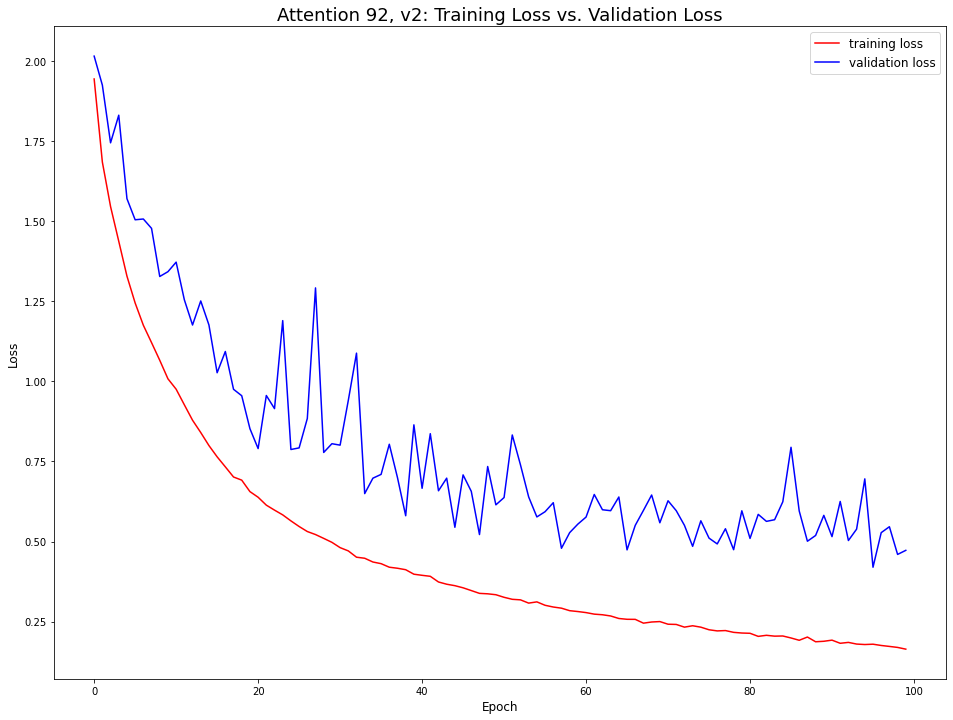

In [15]:
plt.figure(figsize=(16,12))
plt.title("Attention 92, v2: Training Loss vs. Validation Loss", fontsize=18)
plt.plot(ran92_v2_history.history['loss'], label='training loss', color='red')
plt.plot(ran92_v2_history.history['val_loss'], label = 'validation loss', color='blue')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.savefig(plot_loss_filename)
plt.show()

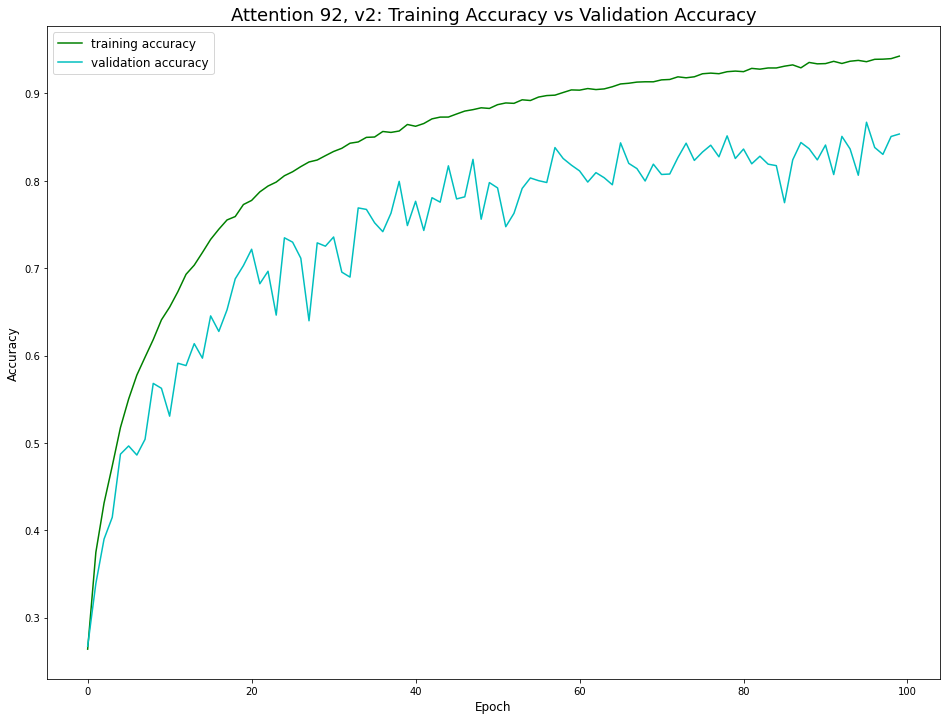

In [16]:
plt.figure(figsize=(16,12))
plt.title("Attention 92, v2: Training Accuracy vs Validation Accuracy", fontsize=18)
plt.plot(ran92_v2_history.history['accuracy'], label='training accuracy', color='g')
plt.plot(ran92_v2_history.history['val_accuracy'], label = 'validation accuracy', color='c')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=12)
plt.savefig(plot_acc_filename)
plt.show()

In [17]:
history_filename = history_path + '/ran92_v2_history_' + time.ctime().replace(' ','_').replace(':','_')
print(history_filename)

./models/ran92_v2_arl/history/ran92_v2_history_Tue_Dec_21_22_36_50_2021


In [20]:
np.save('{}.npy'.format(history_filename),ran92_v2_history.history)

In [19]:
model.save(saved_model_path + '/ran92_v2_ARL')

INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models/ran92_v2_ARL\assets


INFO:tensorflow:Assets written to: ./models/ran92_v2_arl/saved_models/ran92_v2_ARL\assets
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
